In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt  # Added for plotting
from nltk.stem import WordNetLemmatizer
import optuna
import pandas as pd
import pickle
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import torch.nn.functional as F

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [63]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_glove = load_glove_embeddings('glove_files/glove.6B.300d.txt')


In [64]:
embedding_dim = 300
embeddings_glove['<pad>'] = np.zeros(embedding_dim)
embeddings_glove['<unk>'] = np.random.rand(embedding_dim)

In [65]:
with open(r'C:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\embedding_dictionary.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

In [66]:
embedding_dict['<pad>'] = np.zeros(embedding_dim)
embedding_dict['<unk>'] = np.random.rand(embedding_dim)

In [67]:
#find overlapping keys in both dictionaries
common_keys = set(embeddings_glove.keys()) & set(embedding_dict.keys())
print(common_keys)
print(len(embeddings_glove))
print(len(embedding_dict))
print(len(common_keys))


{'off', 'black', 'white', 'woman', 'hollywood', 'double', '<unk>', 'else', 'inevitable', 'weirded', 'heidegger', 'fill-in', 'class', 'a', '<pad>', 're', 'witch', 'character', 'rambo', 'hard', 'less', 'girl', 'television', 'stunning', 'adapted', 'low', 'west', 'self', 'four', 'old-world', 'after', 'hit', 'and', 'super'}
400002
1636
34


In [68]:
#merge both dicts, keeping the values from the glove embeddings
final_dict = {**embedding_dict, **embeddings_glove}
print(len(final_dict))

401604


In [34]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

print(train_dataset[0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [40]:
counter = Counter()
for example in train_dataset:
    tokens = word_tokenize(example['text'])
    counter.update(tokens)

# Vocabulary is the set of unique words
vocab = set(counter.keys())
vocab_size = len(vocab)

print("Size of the vocabulary:", vocab_size)

Size of the vocabulary: 18030


In [41]:
for example in train_dataset:
    tokens = word_tokenize(example['text'])
    print(tokens)

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', '``', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
['the', 'gorgeously', 'elaborate', 'continuation', 'of', '``', 'the', 'lord', 'of', 'the', 'rings', '``', 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co-writer/director', 'peter', 'jackson', "'s", 'expanded', 'vision', 'of', 'j', '.', 'r', '.', 'r', '.', 'tolkien', "'s", 'middle-earth', '.']
['effective', 'but', 'too-tepid', 'biopic']
['if', 'you', 'sometimes', 'like', 'to', 'go', 'to', 'the', 'movies', 'to', 'have', 'fun', ',', 'wasabi', 'is', 'a', 'good', 'place', 'to', 'start', '.']
['emerges', 'as', 'something', 'rare', ',', 'an', 'issue', 'movie', 'that', "'s", 'so', 'honest', 'and', 'keenly', 'observed', 'that', 'it', 'does', "n'

In [88]:
# Create word-to-index and index-to-word mappings
vocab = {}
index = 0
for word, emb in final_dict.items():
    #print(word)
    vocab[word] = index
    index += 1
len(vocab)

401604

In [89]:

embedding_matrix = np.zeros((len(vocab), embedding_dim))


for word, idx in vocab.items():

    embedding_matrix[idx] = final_dict[word]

print(embedding_matrix.shape)

(401604, 300)


In [90]:
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

Epoch 1:
    Train Loss: 0.5917, Train Acc: 0.6860
    Val Loss: 0.5358, Val Acc: 0.7195
Epoch 2:
    Train Loss: 0.5228, Train Acc: 0.7428
    Val Loss: 0.5489, Val Acc: 0.7345
Epoch 3:
    Train Loss: 0.5100, Train Acc: 0.7560
    Val Loss: 0.5729, Val Acc: 0.7158
Epoch 4:
    Train Loss: 0.4869, Train Acc: 0.7720
    Val Loss: 0.5240, Val Acc: 0.7533
Epoch 5:
    Train Loss: 0.4737, Train Acc: 0.7780
    Val Loss: 0.5775, Val Acc: 0.7026
Epoch 6:
    Train Loss: 0.4670, Train Acc: 0.7790
    Val Loss: 0.5638, Val Acc: 0.7148
Epoch 7:
    Train Loss: 0.4533, Train Acc: 0.7910
    Val Loss: 0.5591, Val Acc: 0.7280
Epoch 8:
    Train Loss: 0.4443, Train Acc: 0.7968
    Val Loss: 0.5585, Val Acc: 0.7486
Epoch 9:
    Train Loss: 0.4308, Train Acc: 0.8073
    Val Loss: 0.5787, Val Acc: 0.7083
Epoch 10:
    Train Loss: 0.4129, Train Acc: 0.8149
    Val Loss: 0.5520, Val Acc: 0.7355
Test Loss: 0.5506, Test Acc: 0.7242


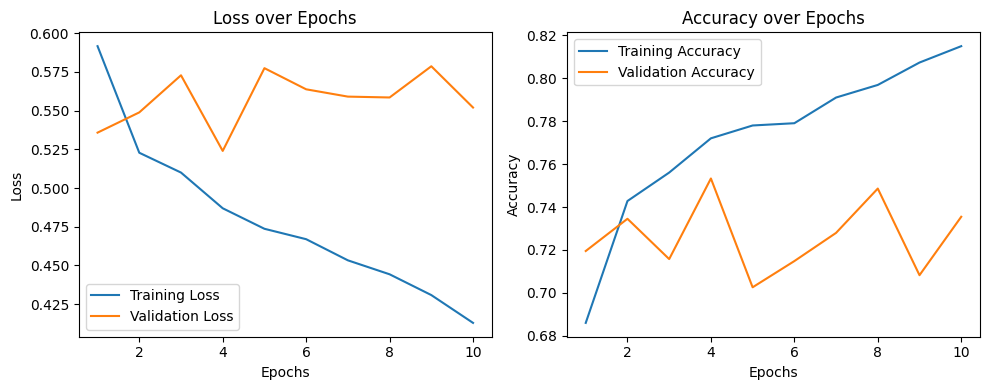

In [93]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 32

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [94]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
    bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create datasets and dataloaders with the suggested batch size
    train_data = RTDataset(train_dataset, vocab)
    valid_data = RTDataset(validation_dataset, vocab)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model, criterion, and optimizer with the suggested hyperparameters
    output_dim = 2  # Negative or Positive sentiment
    model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
        # Optuna requires a numerical value to minimize (or maximize)
        trial.report(valid_loss, epoch)
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-10-25 14:24:55,143] A new study created in memory with name: no-name-b88038c7-b5c5-44d5-a8e1-6367389bc0e3
C:\Users\Admin\AppData\Local\Temp\ipykernel_48976\1897618869.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-10-25 14:25:41,648] Trial 0 finished with value: 0.6376347300259302 and parameters: {'hidden_dim': 320, 'bidirectional': False, 'lr': 0.002090893293039391, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6376347300259302.
[I 2024-10-25 14:26:22,700] Trial 1 finished with value: 0.7026770085823245 and parameters: {'hidden_dim': 256, 'bidirectional': True, 'lr': 0.014565400640165581, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6376347300259302.
[I 2024-10-25 14:27:11,629] Trial 2 finished with value: 0.68

Number of finished trials: 20
Best trial:
  Value: 0.5397
  Params:
    hidden_dim: 448
    bidirectional: False
    lr: 0.0004280691504528864
    batch_size: 64
    optimizer: Adam


In [95]:
#use bilstm instead of rnn
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional=True):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :]
        output = self.fc(hidden)
        return output

In [104]:
# Instantiate the BiLSTM model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment
bidirectional = True

#train the model
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1:
    Train Loss: 0.5584, Train Acc: 0.7052
    Val Loss: 0.5092, Val Acc: 0.7617
Epoch 2:
    Train Loss: 0.4761, Train Acc: 0.7710
    Val Loss: 0.4715, Val Acc: 0.7692
Epoch 3:
    Train Loss: 0.4409, Train Acc: 0.7800
    Val Loss: 0.4594, Val Acc: 0.7871
Epoch 4:
    Train Loss: 0.4141, Train Acc: 0.8082
    Val Loss: 0.5711, Val Acc: 0.7458
Epoch 5:
    Train Loss: 0.3773, Train Acc: 0.8249
    Val Loss: 0.4680, Val Acc: 0.7711
Epoch 6:
    Train Loss: 0.3301, Train Acc: 0.8532
    Val Loss: 0.4815, Val Acc: 0.7702
Epoch 7:
    Train Loss: 0.2805, Train Acc: 0.8771
    Val Loss: 0.5494, Val Acc: 0.7580
Epoch 8:
    Train Loss: 0.2246, Train Acc: 0.9061
    Val Loss: 0.5972, Val Acc: 0.7711
Epoch 9:
    Train Loss: 0.1637, Train Acc: 0.9329
    Val Loss: 0.6797, Val Acc: 0.7505
Epoch 10:
    Train Loss: 0.1136, Train Acc: 0.9585
    Val Loss: 0.7698, Val Acc: 0.7627
Test Loss: 0.8211, Test Acc: 0.7505


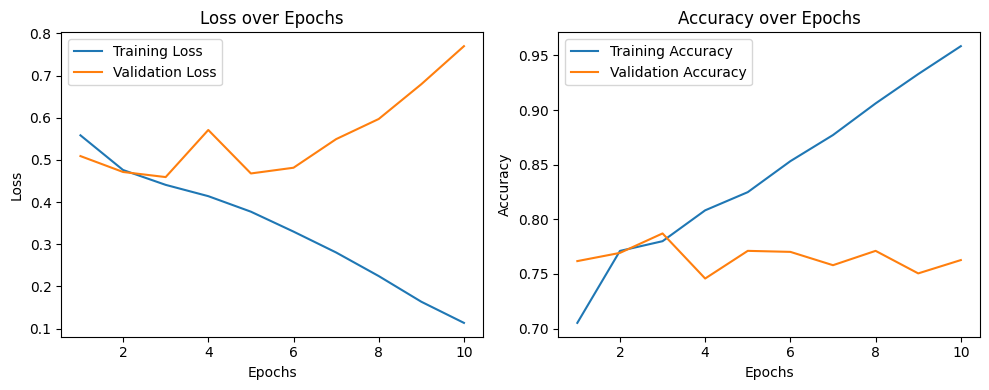

In [105]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
#use biGRU instead of biLSTM

class BiGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional=True):
        super(BiGRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.gru.bidirectional else hidden[-1, :, :]
        output = self.fc(hidden)
        return output

# Instantiate the BiGRU model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment
bidirectional = True

model = BiGRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.5515, Train Acc: 0.7148
    Val Loss: 0.4841, Val Acc: 0.7692
Epoch 2:
    Train Loss: 0.4604, Train Acc: 0.7764
    Val Loss: 0.4785, Val Acc: 0.7608
Epoch 3:
    Train Loss: 0.4269, Train Acc: 0.7978
    Val Loss: 0.4471, Val Acc: 0.7908
Epoch 4:
    Train Loss: 0.3958, Train Acc: 0.8145
    Val Loss: 0.4434, Val Acc: 0.7889
Epoch 5:
    Train Loss: 0.3517, Train Acc: 0.8455
    Val Loss: 0.4855, Val Acc: 0.7739
Epoch 6:
    Train Loss: 0.3064, Train Acc: 0.8646
    Val Loss: 0.4845, Val Acc: 0.7608
Epoch 7:
    Train Loss: 0.2473, Train Acc: 0.8932
    Val Loss: 0.5396, Val Acc: 0.7570
Epoch 8:
    Train Loss: 0.1872, Train Acc: 0.9253
    Val Loss: 0.6307, Val Acc: 0.7533
Epoch 9:
    Train Loss: 0.1299, Train Acc: 0.9476
    Val Loss: 0.7219, Val Acc: 0.7608
Epoch 10:
    Train Loss: 0.0817, Train Acc: 0.9715
    Val Loss: 0.8836, Val Acc: 0.7627
Test Loss: 0.9327, Test Acc: 0.7430


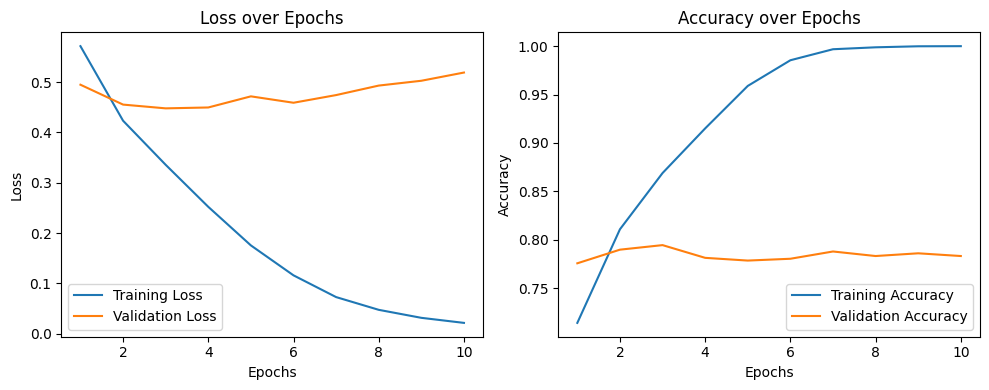

In [103]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [108]:

#use CNN instead of RNN
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_filters, filter_sizes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output

# Instantiate the CNN model, loss function, and optimizer
num_filters = 64
filter_sizes = [6, 5, 7]

model = CNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_filters, filter_sizes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008221278508915971)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')




Epoch 1:
    Train Loss: 0.5378, Train Acc: 0.7149
    Val Loss: 0.4820, Val Acc: 0.7674
Epoch 2:
    Train Loss: 0.3744, Train Acc: 0.8349
    Val Loss: 0.4624, Val Acc: 0.7749
Epoch 3:
    Train Loss: 0.2100, Train Acc: 0.9298
    Val Loss: 0.4920, Val Acc: 0.7814
Epoch 4:
    Train Loss: 0.0825, Train Acc: 0.9872
    Val Loss: 0.5567, Val Acc: 0.7749
Epoch 5:
    Train Loss: 0.0281, Train Acc: 0.9980
    Val Loss: 0.6128, Val Acc: 0.7795
Epoch 6:
    Train Loss: 0.0210, Train Acc: 0.9985
    Val Loss: 0.6498, Val Acc: 0.7749
Epoch 7:
    Train Loss: 0.0113, Train Acc: 0.9995
    Val Loss: 0.6802, Val Acc: 0.7758
Epoch 8:
    Train Loss: 0.0038, Train Acc: 1.0000
    Val Loss: 0.6990, Val Acc: 0.7777
Epoch 9:
    Train Loss: 0.0025, Train Acc: 1.0000
    Val Loss: 0.7236, Val Acc: 0.7749
Epoch 10:
    Train Loss: 0.0019, Train Acc: 1.0000
    Val Loss: 0.7465, Val Acc: 0.7795


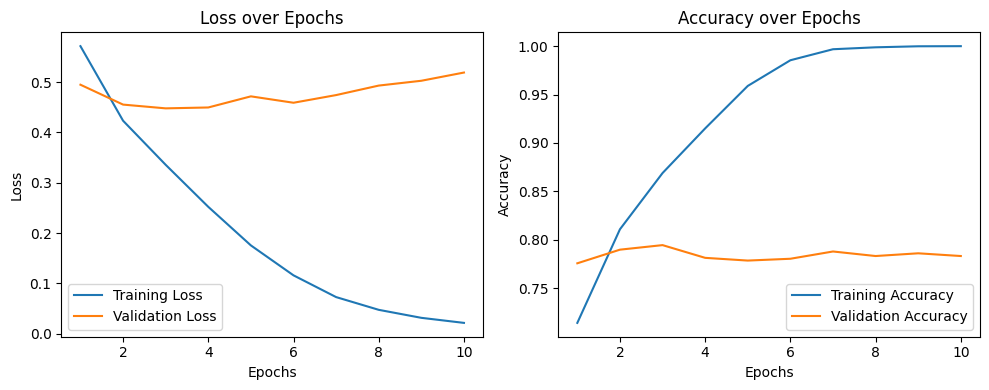

In [102]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
#optuna for CNN

def objective(trial):
        
        # Suggest hyperparameters
        num_filters = trial.suggest_int('num_filters', 64, 128, step=16)
        filter_sizes = [trial.suggest_int('filter_size_1', 3, 7, step=1),
                        trial.suggest_int('filter_size_2', 3, 7, step=1),
                        trial.suggest_int('filter_size_3', 3, 7, step=1)]
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab)
        valid_data = RTDataset(validation_dataset, vocab)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        model = CNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_filters, filter_sizes)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

    


[I 2024-10-25 14:47:59,042] A new study created in memory with name: no-name-71e08393-0d63-4a1f-b0f4-bc8394d1cb26
C:\Users\Admin\AppData\Local\Temp\ipykernel_48976\2729771473.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-10-25 14:48:47,175] Trial 0 finished with value: 1.1939000859437248 and parameters: {'num_filters': 64, 'filter_size_1': 5, 'filter_size_2': 3, 'filter_size_3': 7, 'lr': 0.06952158359309604, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 0 with value: 1.1939000859437248.
[I 2024-10-25 14:49:39,212] Trial 1 finished with value: 0.653582724800253 and parameters: {'num_filters': 64, 'filter_size_1': 6, 'filter_size_2': 5, 'filter_size_3': 7, 'lr': 0.0008221278508915971, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.6535827

Number of finished trials: 20
Best trial:
  Value: 0.6536
  Params:
    num_filters: 64
    filter_size_1: 6
    filter_size_2: 5
    filter_size_3: 7
    lr: 0.0008221278508915971
    batch_size: 64
    optimizer: Adam
